$\newcommand{\TirName}[1]{\text{#1}}
\newcommand{\inferrule}[3][]{
  \let\and\qquad
  \begin{array}{@{}l@{}}
  \TirName{#1}
  \\
  \displaystyle
  \frac{#2}{#3}
  \end{array}
}
\newcommand{\infer}[3][]{\inferrule[#1]{#2}{#3}}
$

# Meeting 19 - Encapsulating Effects

Bor-Yuh Evan Chang  
Saturday, October 26, 2024

<!-- 3 Expressions -->

<!-- 4 Binding and Scope -->

<!-- 8 Recursion -->

<!-- 9 Inductive Data Types -->

<!-- 11 Concrete Syntax -->

<!-- 12 Abstract Syntax and Parsing -->

<!-- 13 Exercise: Syntax -->

<!-- 14 Static Scoping -->

<!-- 15 Judgments -->

<!-- 16 Variables, Basic Values, and Judgments Lab -->

<!-- 18 Operational Semantics -->

<!-- 19 Functions and Dynamic Scoping -->

<!-- 20 Big-Step Exercise -->

<!-- 21 Evaluation Order  -->

<!-- Static Typing -->

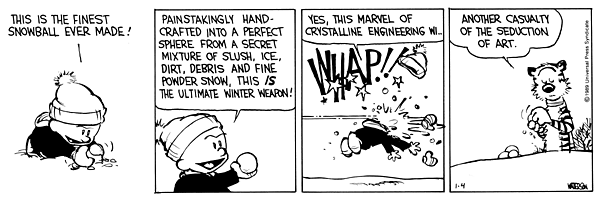

What questions does your neighbor have?

## Links

[ In-Class Slides](in-class/meeting19-encapsulating-effects.pdf)<br/> [
In-Class Jupyter](in-class/meeting19-encapsulating-effects.ipynb)<br/> [
Book
Chapter](https://csci3155.cs.colorado.edu/pppl-course/book/static-type-checking-lab.html)

## Announcements

-   Lab 4 due ~~Monday~~ Tuesday 6pm
    -   Implement static typing (from last Tuesday’s chapter and
        lecture)
    -   Apply higher-order methods for `List` and `Map` from HW4
    -   For immutable objects and multi-parameter functions, reading
        semantics
-   Lab 4 Leaderboards (Nastiness and Robustness competitions for extra
    credit).
-   Review 3-4 Thursday and Friday
    -   Sign up on Canvas – needed to get assignment points
    -   Scored on the quality of your feedback for your partner, not how
        you were assessed by your partner
    -   Submit on Gradescope as a group — to get each other’s feedback
    -   0 for no-shows
-   Exam 3-4 next Tuesday 11/5
    -   50 minutes in class

## Today

-   Triage Your Questions
    -   Static Type Checking?
    -   Higher-Order Functions?
-   [Encapsulating
    Effects](https://csci3155.cs.colorado.edu/pppl-course/book/encapsulating-effects.html)

## Questions?

-   Review:
    -   What is static type checking and what is the benefit?

## Questions?

# Error Effects

## Exceptions

In [2]:
def toDoubleException(s: String): Double = s.toDouble

toDoubleException("1")
toDoubleException("4.2")

defined function toDoubleException 
 res0_1 : Double = 1.0 
 res0_2 : Double = 4.2

## Option

In [3]:
def toDoubleOption(s: String): Option[Double] = ???

defined function toDoubleOption

In [4]:
def toDoubleNoNaNOption(s: String): Option[Double] = ???

defined function toDoubleNoNaNOption

## Option as a Collection

In [8]:
def toDoubleNoNaNOption(s: String): Option[Double] = ???

defined function toDoubleNoNaNOption

In [9]:
def addToDoubleOption(s1: String, s2: String): Option[Double] = ???

defined function addToDoubleOption

## Map, Filter, FlatMap

<span class="theorem-title">**Exercise 1**</span> Implement `map` for
`Option[A]`s:

In [12]:
def map[A,B](opt: Option[A])(f: A => B): Option[B] = ???

defined function map

<span class="theorem-title">**Exercise 2**</span> Implement `filter` for
`Option[A]`s:

In [13]:
def filter[A](opt: Option[A])(f: A => Boolean): Option[A] = ???

defined function filter

<span class="theorem-title">**Exercise 3**</span> Implement `flatMap`
for `Option[A]`s:

In [14]:
def flatMap[A,B](opt: Option[A])(f: A => Option[B]): Option[B] = ???

defined function flatMap

## Comprehensions

In [15]:
def addToDoubleOption(s1: String, s2: String): Option[Double] = ???

defined function addToDoubleOption

## Either and Try

In [17]:
def toDoubleEither(s: String): Either[NumberFormatException, Double] = ???

def addToDoubleEither(s1: String, s2: String): Either[NumberFormatException, Double] =
  for {
    d1 <- toDoubleEither(s1)
    d2 <- toDoubleEither(s2)
  } yield d1 + d2

defined function toDoubleEither 
defined function addToDoubleEither

In [18]:
import scala.util.Try
def toDoubleTry(s: String): Try[Double] = ???

def addToDoubleTry(s1: String, s2: String): Try[Double] =
  for {
    d1 <- toDoubleTry(s1)
    d2 <- toDoubleTry(s2)
  } yield d1 + d2

import scala.util.Try
 defined function toDoubleTry 
defined function addToDoubleTry

## Mutation Effects

In [21]:
def freshVarImperative: String = ???

defined function freshVarImperative

In [22]:
def freshVar: Int => (Int, String) = ???

defined function freshVar

## Encapsulating Mutation Effects

In [26]:
type DoWith[S, A] = S => (S, A)

defined type DoWith

In [27]:
freshVar: DoWith[Int, String]

res25 : Int => ( Int , String ) = ammonite.$sess.cmd22$Helper$$Lambda$2244/0x0000000800b87840@3d5721bd

In [28]:
def map[S,A,B](doer: DoWith[S,A])(f: A => B): DoWith[S,B] = ???

defined function map

In [29]:
def flatMap[S,A,B](doer: DoWith[S,A])(f: A => DoWith[S,B]): DoWith[S,B] = ???

defined function flatMap

In [30]:
val counter = 0

counter : Int = 0

## DoWith

In [34]:
sealed class DoWith[S,A] private (doer: S => (S, A)) {
  def map[B](f: A => B): DoWith[S,B] = new DoWith[S,B]({
    (s: S) => {
      val (s_, a) = doer(s)
      (s_, f(a))
    }
  })

  def flatMap[B](f: A => DoWith[S,B]): DoWith[S,B] = new DoWith[S,B]({
    (s: S) => {
      val (s_, a) = doer(s)
      f(a)(s_)
    }
  })

  def apply(s: S): (S, A) = doer(s)
}

object DoWith {
  def doget[S]: DoWith[S,S] = new DoWith[S,S]({ s => (s, s) })
  def doput[S](s: S): DoWith[S,Unit] = new DoWith[S,Unit]({ _ => (s, ()) })
  def doreturn[S,A](a: A): DoWith[S,A] = doget map { _ => a } 
  def domodify[S](f: S => S): DoWith[S,Unit] = doget flatMap { s => doput(f(s)) }
}

import DoWith._

defined class DoWith 
defined object DoWith 
 import DoWith._

In [35]:
def freshVar: DoWith[Int,String] = ???

defined function freshVar

In [36]:
val counter = 0

counter : Int = 0